# Fully Convolution Autoencoder for Anomaly Detection
In this project I am going to lay out a simple structure for a fully convolutional autoencoder (CAE), train it on images of healthy berries and validate it on how good it is able to reconstruct such healthy berries. I will experiment with various loss functions and adjust the training parameters accordinlgy. Then I am going to fine tune a threshold for the loss value and test the autoencoder with both healthy and anomalous berries. I will evaluate the results obtained and compute statistics to better understand the model's behaviour.





Importing the needed libraries.

In [3]:
import os
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
mse_loss = nn.MSELoss()
from torch import optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset, Dataset

!pip install torchmetrics
import torchvision.transforms as transforms
from torchmetrics.classification import Accuracy
from skimage.metrics import structural_similarity as ssim
import random


Enable use of GPU and set random seeds.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

Device in use: cuda


# Exploratory Data Analysis (EDA)
I create a classic PyTorch dataset class, thanks to which I can later create dataloaders for training and validation, I will also implement data augmentation, in particular random flipping, as suggested in the paper.
For training I am going to use 2/3 of each directory containing healthy berries.
The random flip is applied to each image with a probability of 50%.

In [6]:

# Define the paths to the directories containing the patches
healthy_directory_1 = "/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/good/scale_1/"
healthy_directory_1_5 = "/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/good/scale_1.5/"
healthy_directory_2 = "/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/good/scale_2/"
anomaly_directory_1 = "/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/bad/scale_1/"
anomaly_directory_1_5 = "/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/bad/scale_1.5/"
anomaly_directory_2 = "/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/bad/scale_2/"

# Create a set to contain healthy berries paths
used_file_paths = set()

# Function to calculate the number of healthy images to use for training in each directory
def calculate_num_healthy_images(directory):
    num_images = len(os.listdir(directory))
    num_healthy_images_for_training = (2 * num_images) // 3
    return num_healthy_images_for_training

# Define a custom dataset for loading and augmenting the healthy patches
class TrainDataset(Dataset):
    def __init__(self, directory, num_healthy_for_training, augment=True):
        self.directory = directory
        self.num_healthy_for_training = num_healthy_for_training
        self.augment = augment
        self.file_paths = self.get_file_paths()
        self.update_used_file_paths()  # Update the used_file_paths set here

    def get_file_paths(self):
        file_names = [file_name for file_name in os.listdir(self.directory) if file_name.endswith(".jpg")]
        file_paths = [os.path.join(self.directory, file_name) for file_name in file_names]
        return file_paths

    def update_used_file_paths(self):
        global used_file_paths
        used_file_paths.update(self.file_paths[:self.num_healthy_for_training])  # Mark training file paths as used

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]

        try:
            image = Image.open(file_path).convert("RGB")
            image = image.resize((293, 293))

            if self.augment:
                image = self.apply_augmentation(image)

            # Pixel values automatically normalized
            tensor_image = transforms.ToTensor()(image)

            return tensor_image

        except Exception as e:
            print(f"Error loading image: {file_path}")
            print(e)
            return None

    def apply_augmentation(self, image):
        transform = transforms.RandomHorizontalFlip(p=0.5)
        augmented_image = transform(image)
        return augmented_image

# Calculate the number of healthy images to use for training from each directory
num_healthy_directory_1 = calculate_num_healthy_images(healthy_directory_1)
num_healthy_directory_1_5 = calculate_num_healthy_images(healthy_directory_1_5)
num_healthy_directory_2 = calculate_num_healthy_images(healthy_directory_2)

train_dataset_1 = TrainDataset(directory=healthy_directory_1, num_healthy_for_training=num_healthy_directory_1, augment=True)
train_dataset_1_5 = TrainDataset(directory=healthy_directory_1_5, num_healthy_for_training=num_healthy_directory_1_5, augment=True)
train_dataset_2 = TrainDataset(directory=healthy_directory_2, num_healthy_for_training=num_healthy_directory_2, augment=True)
train_dataset_unsplit = ConcatDataset([train_dataset_1, train_dataset_1_5, train_dataset_2])

# Split the train_dataset into training and validation datasets in an 80-20 ratio
train_size = int(0.8 * len(train_dataset_unsplit))
val_size = len(train_dataset_unsplit) - train_size
train_dataset, val_dataset = random_split(train_dataset_unsplit, [train_size, val_size])

# Check size of training and validation datasets
print(f"Size of train dataset: {len(train_dataset)}")
print(f"Size of validation dataset: {len(val_dataset)}")


Size of train dataset: 788
Size of validation dataset: 197


Now that we can access the data, let's explore it. We have images of various scales, each patchs is going to be resized to meet the expectations of the autoencoder. In particular, the training, as stated in the paper, is going to be conducted only with healthy berries. We will keep doing EDA on the anomalous berries when we create the test datasets. Also, the objective here is to teach the autoencoder to classify healthy and anomalous berries, to do so we want the autoencoder to learn well how to reconstruct healthy berries, so that as soon as it tries to reconstruct an anomalous berry, the loss is going to increase, raising above a certain optimal threshold and triggering the autoencoder to classify the berry as anomalous. The problem is a classification problem.

Image 158 has size: torch.Size([3, 293, 293])
Image 79 has size: torch.Size([3, 293, 293])
Image 372 has size: torch.Size([3, 293, 293])
Image 7 has size: torch.Size([3, 293, 293])
Image 638 has size: torch.Size([3, 293, 293])


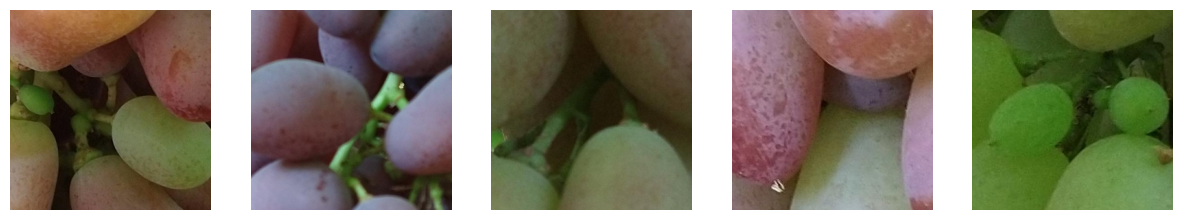

In [7]:
def plot_images(dataset, num_images=5, random_seed=42, labeled=False):
    torch.manual_seed(random_seed)
    indices = torch.randperm(len(dataset))[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    if(not labeled):
      for i, idx in enumerate(indices):
          image = dataset[idx]
          print(f"Image {idx} has size: {image.shape}")
          image = np.transpose(image.numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
          axes[i].imshow(image)
          axes[i].axis("off")

    else:
      for i, idx in enumerate(indices):
          image = dataset[idx][0]
          print(f"Image {idx} has size: {image.shape}")
          image = np.transpose(image.numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
          axes[i].imshow(image)
          axes[i].axis("off")

    plt.show()

num_images_to_plot = 5
plot_images(train_dataset, num_images=num_images_to_plot)


Let's define the architecture of the Convolution AutoEncoder (CAE), trying to match the architecture suggested in the paper.
In this phase we will also create the dataloaders for training and validation and run the training and validation cycle. After the training has ended we will then plot the training and validation loss curves using Matplotlib.

In [ ]:
# Run this section if you want to later reload the saved model
class AllConvAutoencoder(nn.Module):
    def __init__(self):
        super(AllConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=9, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 18, kernel_size=9, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(18, 20, kernel_size=9, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(20, 22, kernel_size=9, stride=3),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(22, 20, kernel_size=9, stride=3),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(20, 18, kernel_size=9, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(18, 16, kernel_size=9, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=9, stride=1),
            nn.LeakyReLU()
        )

        # Initialize weights with Xavier (Glorot) uniform initialization
        # Weights randomly set from a uniform distribution with specific range
        # Range depends on input and output units of weights tensor
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create an instance of the autoencoder
autoencoder = AllConvAutoencoder()

# Move the autoencoder to the GPU if available (else, to the CPU)
autoencoder = autoencoder.to(device)

AllConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 18, kernel_size=(9, 9), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(18, 20, kernel_size=(9, 9), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(20, 22, kernel_size=(9, 9), stride=(3, 3))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(22, 20, kernel_size=(9, 9), stride=(3, 3))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(20, 18, kernel_size=(9, 9), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(18, 16, kernel_size=(9, 9), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(16, 3, kernel_size=(9, 9), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
)
772
=== Training Start ===
Batch no. 1/24	Epoch 0
Batch no. 2/24	Epoch 0
Batch no. 3/24	Epoch 

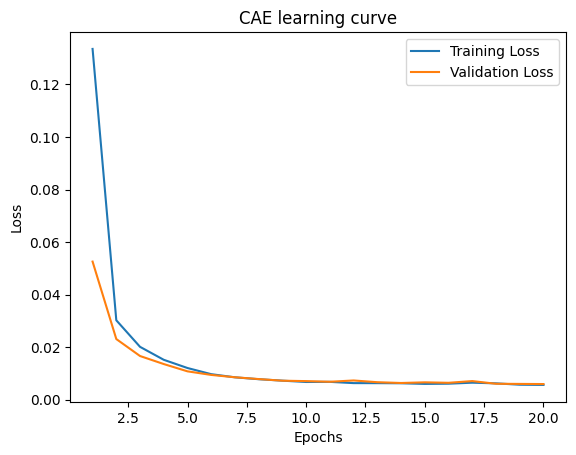

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

'''
The convolutional kernel size is 9 × 9 for every layer with a stride
of 1-2-2-3 and a number of feature maps of 16-18-20-22.
As activation function, we use leaky RELU.
'''

# Define the architecture of the all-convolutional autoencoder
class AllConvAutoencoder(nn.Module):
    def __init__(self):
        super(AllConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=9, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 18, kernel_size=9, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(18, 20, kernel_size=9, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(20, 22, kernel_size=9, stride=3),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(22, 20, kernel_size=9, stride=3),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(20, 18, kernel_size=9, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(18, 16, kernel_size=9, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=9, stride=1),
            nn.LeakyReLU()
        )

        # Initialize weights with Xavier (Glorot) uniform initialization
        # Weights randomly set from a uniform distribution with specific range
        # Range depends on input and output units of weights tensor
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create an instance of the autoencoder
autoencoder = AllConvAutoencoder()

# Move the autoencoder to the GPU if available (else, to the CPU)
autoencoder = autoencoder.to(device)
print(autoencoder)

# Define the optimizer and loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Set the number of epochs and the batch size
num_epochs = 20
batch_size = 32

# Create the data loader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

print(len(used_file_paths))

# Initialize data for graphs
train_losses = []
validation_losses = []

# Training loop
autoencoder.train()
print("=== Training Start ===")
for epoch in range(num_epochs):
    autoencoder.train()  # Set the model to training mode
    train_loss = 0.0
    batch_num = 0
    for data in train_dataloader:
        data = data.to(device)

        # Forward pass
        output = autoencoder(data)

        # Compute the loss
        loss = criterion(output, data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute final loss and scale it
        train_loss += loss.item() * data.size(0)

        batch_num += 1
        print(f"Batch no. {batch_num}/{len(train_dataloader)}\tEpoch {epoch}")

    # Compute the average training loss for the current epoch
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Validation
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_data in val_dataloader:
            val_data = val_data.to(device)
            val_output = autoencoder(val_data)
            val_loss += criterion(val_output, val_data).item() * val_data.size(0)

    # Compute the average validation loss for the current epoch
    val_loss /= len(val_dataloader.dataset)
    validation_losses.append(val_loss)

    # Print the loss for every epoch
    print(f"\nEpoch {epoch+1}/{num_epochs}\tTraining Loss: {train_loss}\tValidation Loss: {val_loss}\n")

print("=== Training End ===")

# Plot training and validation loss
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, validation_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CAE learning curve')
plt.legend()
plt.show()


# Experimenting with training parameters (Ablation Study)

Let's experiment with different loss functions.
This is the result when we use Mean Squared Error (MSE) as loss function to train and validate the neural network.

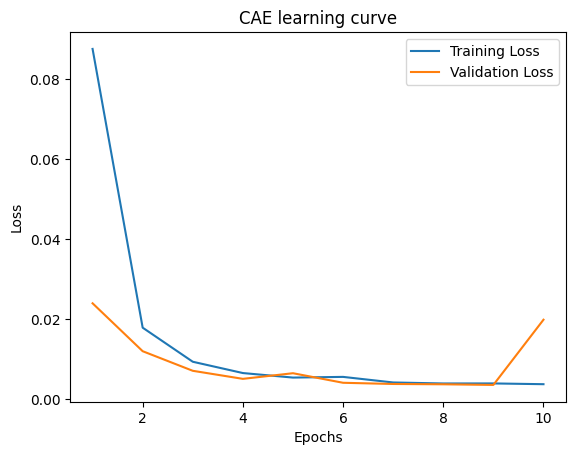

We can see that after some epochs the model overfits. Now let's increase the batch_size to 64 and see if anything changes.

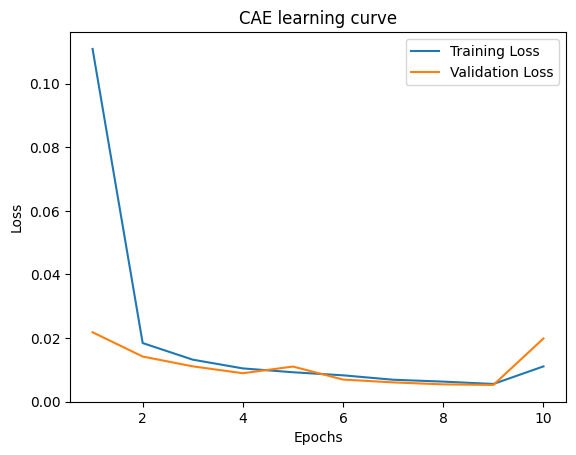

Very little has changed, and we decide that it is better to stop at epoch 8 to prevent the model from overfitting when using lr = 0.001.

Now let's try to use BCEWithLogitsLoss (stable version of nn.BCE()) to train and validate the neural network.

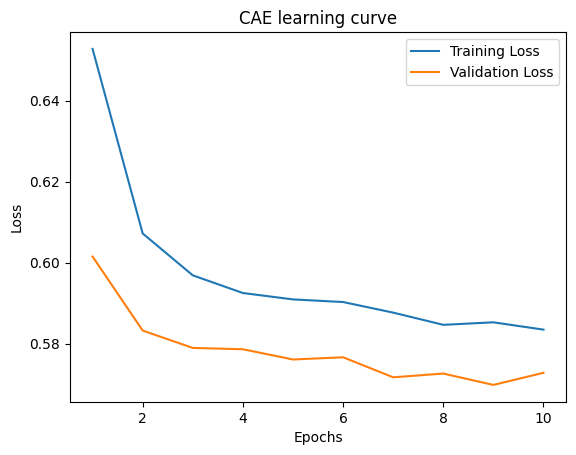

We observe that the loss value is generally higher and that the same amount of epochs used with MSE is not enough to observe convergence and (eventually) overfitting.

Since the losses aren't "catching up" quickly we decide it is worth to experiment with a higher value of learning rate, lr=0.01 (until now we have used lr=0.001), and keep a batch_size of 64.

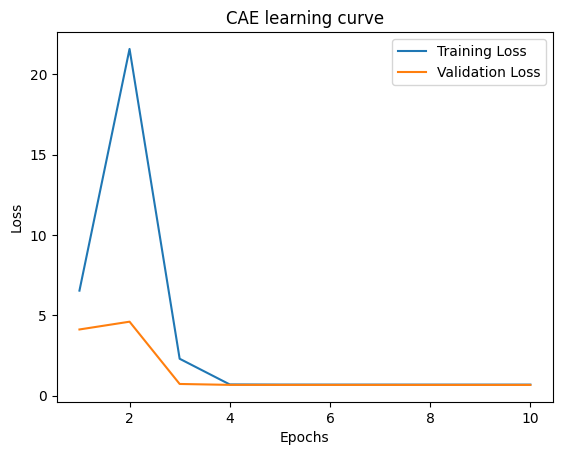

As expected, thanks to the higher lr the model reaches convergence much sonner, I believe that the initial huge spike in the training loss must be caused by data augmentation.

In the end, we have obtained the best result by using MSE, let's just decrease the number of epochs so that the model doesn't overfit.

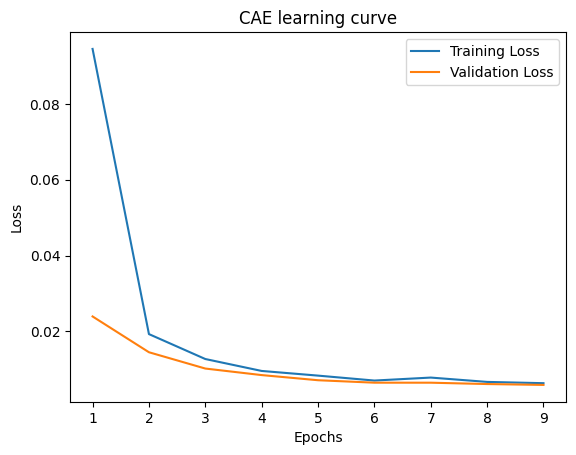

I consider this an optimal result, I have used a batch_size of 16, with MSE as loss function and I stopped at epoch 9 to prevent overfitting on the training data.

Let's take a look at the weights and biases computed for each layer.


In [ ]:
for name, param in autoencoder.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter encoder.0.weight, shape torch.Size([16, 3, 9, 9])
Parameter encoder.0.bias, shape torch.Size([16])
Parameter encoder.2.weight, shape torch.Size([18, 16, 9, 9])
Parameter encoder.2.bias, shape torch.Size([18])
Parameter encoder.4.weight, shape torch.Size([20, 18, 9, 9])
Parameter encoder.4.bias, shape torch.Size([20])
Parameter encoder.6.weight, shape torch.Size([22, 20, 9, 9])
Parameter encoder.6.bias, shape torch.Size([22])
Parameter decoder.0.weight, shape torch.Size([22, 20, 9, 9])
Parameter decoder.0.bias, shape torch.Size([20])
Parameter decoder.2.weight, shape torch.Size([20, 18, 9, 9])
Parameter decoder.2.bias, shape torch.Size([18])
Parameter decoder.4.weight, shape torch.Size([18, 16, 9, 9])
Parameter decoder.4.bias, shape torch.Size([16])
Parameter decoder.6.weight, shape torch.Size([16, 3, 9, 9])
Parameter decoder.6.bias, shape torch.Size([3])


We will save the weights and the bias computed for each layer inside the state dictionary. This way we can, if we want, reload the model with the same parameters.

In [ ]:
state_dict = autoencoder.state_dict()
torch.save(state_dict, "saved_model_3.tar")
state_dict = torch.load("saved_model_3.tar")

new_autoencoder = AllConvAutoencoder()
new_autoencoder = new_autoencoder.to(device)
new_autoencoder.load_state_dict(state_dict)

<All keys matched successfully>

Now let's take an anomalous and an healthy image, plug them into the autoencoder and see how well it can reconstruct them.

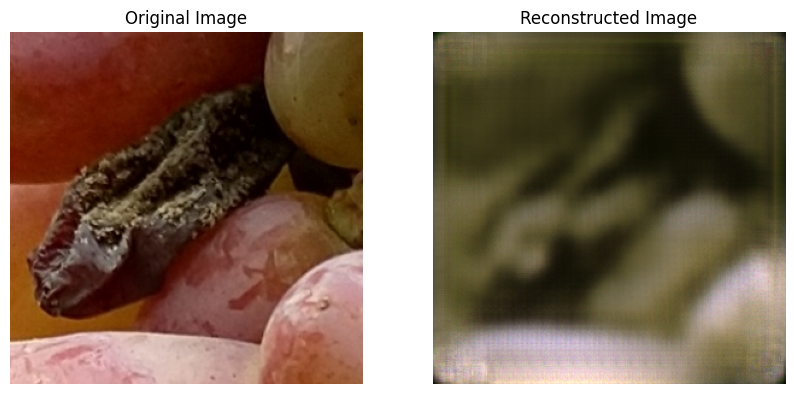

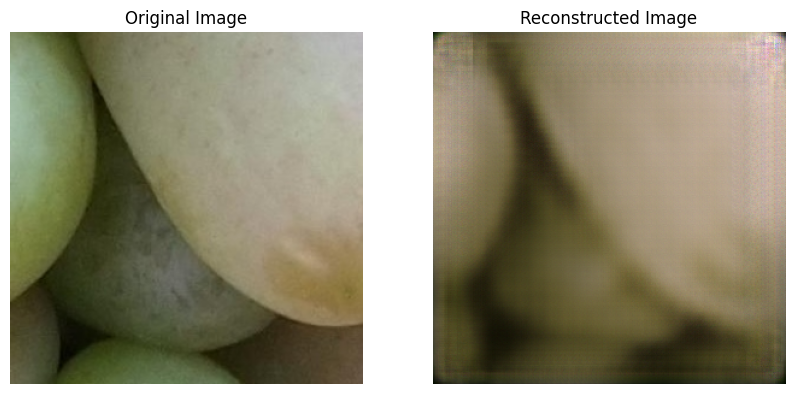

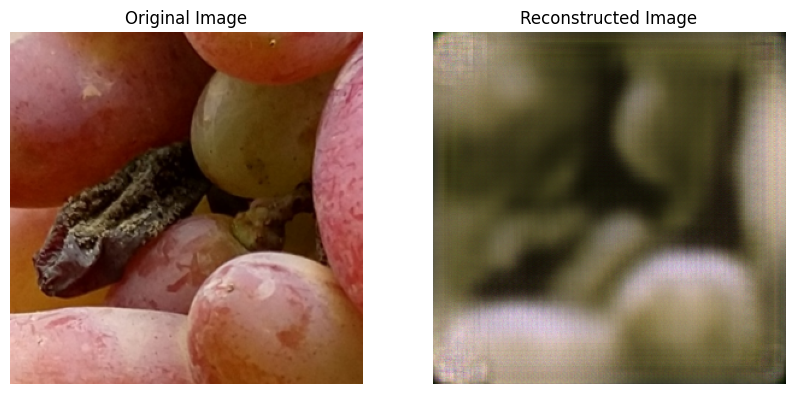

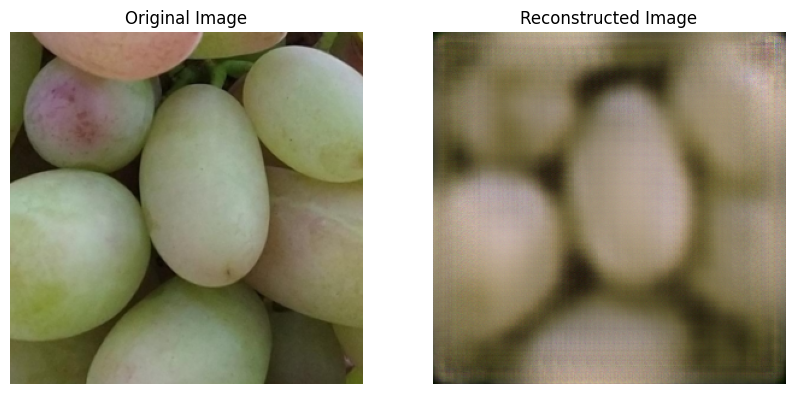

In [9]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # Load the image using PIL
    image = Image.open(image_path)

    # Resize and transform to Tensor
    input_size = (293, 293)
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    return image_tensor

def visualize_original_and_reconstructed(image_path, autoencoder):
    # Load and preprocess the input image
    input_image_tensor = preprocess_image(image_path)

    # Move the autoencoder to the same device as the input image
    device = next(autoencoder.parameters()).device
    autoencoder = autoencoder.to(device)

    # Pass the input image through the model to get the output
    with torch.no_grad():
        autoencoder.eval()
        output_image_tensor = autoencoder(input_image_tensor.to(device))

    # Convert tensors to numpy arrays and visualize the images
    input_image_np = input_image_tensor.squeeze(0).cpu().detach().numpy()
    output_image_np = output_image_tensor.squeeze(0).cpu().detach().numpy()

    input_image_np = np.clip(input_image_np, 0, 1)
    output_image_np = np.clip(output_image_np, 0, 1)

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_image_np.transpose(1, 2, 0))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(output_image_np.transpose(1, 2, 0))
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')

    plt.show()

# Let's show some reconstructions:
input_image_path = '/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/bad/scale_1/IMG_20210924_124738392_HDR_00.jpg'
visualize_original_and_reconstructed(input_image_path, autoencoder)
input_image_path_2 = '/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/good/scale_1/IMG_20210924_121801912_0_00.jpg'
visualize_original_and_reconstructed(input_image_path_2, autoencoder)
input_image_path_3 = '/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/bad/scale_1.5/IMG_20210924_124738392_HDR_00.jpg'
visualize_original_and_reconstructed(input_image_path_3, autoencoder)
input_image_path_4 = '/content/drive/MyDrive/Thesis/dati/cropped patches/first_dataset/good/scale_2/IMG_20210924_121801912_0_00.jpg'
visualize_original_and_reconstructed(input_image_path_4, autoencoder)

Now we are going to create two datasets, one containing healthy berries only, the other one containing anomalous berries only. Having those two datasets separate for now will be useful to compute statistics needed for fine tuning the threshold value.

For training the "remaining" 1/3 of images of healthy berries from each directory will be used, together will all the available images of anomalous berries.

In [10]:
# Define a custom dataset for testing
class TestDataset(Dataset):
    def __init__(self, directory_label_pairs, num_healthy_for_testing, patch_size=293):
        self.directory_label_pairs = directory_label_pairs
        self.num_healthy_for_testing = num_healthy_for_testing
        self.patch_size = patch_size
        self.image_paths_labels = self._load_image_paths_labels()

    def __len__(self):
        return len(self.image_paths_labels)

    def __getitem__(self, index):
        file_path, label = self.image_paths_labels[index]

        # Open the image and convert to RGB
        image = Image.open(file_path).convert("RGB")

        # Resize the image to the desired patch size
        image = image.resize((self.patch_size, self.patch_size))

        # Convert the image to a PyTorch tensor
        tensor_image = transforms.ToTensor()(image)

        return tensor_image, label

    def _load_image_paths_labels(self):
        image_paths_labels = []
        for directory, label in self.directory_label_pairs:
            for filename in os.listdir(directory):
                if filename.lower().endswith(".jpg"):
                    image_path = os.path.join(directory, filename)
                    # Check if the image is from a healthy directory and if it has been used during training
                    if label == 0 and image_path in used_file_paths:
                        continue  # Skip the image as it has been used for training
                    image_paths_labels.append((image_path, label))
        return image_paths_labels

# Use the class to create test datasets
healthy_directory_label_pairs = [
    (healthy_directory_1, 0),
    (healthy_directory_1_5, 0),
    (healthy_directory_2, 0)
]

anomalous_directory_label_pairs = [
    (anomaly_directory_1, 1),
    (anomaly_directory_1_5, 1),
    (anomaly_directory_2, 1)
]

# unused --
num_healthy_for_testing = len(train_dataset) // 3

healthy_test_dataset = TestDataset(healthy_directory_label_pairs, num_healthy_for_testing)
anomaly_test_dataset = TestDataset(anomalous_directory_label_pairs, num_healthy_for_testing)
print(f"Size of healthy test dataset: {len(healthy_test_dataset)}")
print(f"Size of anomaly test dataset: {len(anomaly_test_dataset)}")

directory_label_pairs = healthy_directory_label_pairs + anomalous_directory_label_pairs
test_dataset = TestDataset(directory_label_pairs, num_healthy_for_testing)
print(f"Size of test dataset: {len(test_dataset)}")

# Create the test dataloaders
healthy_dataloader = DataLoader(healthy_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
anomaly_dataloader = DataLoader(anomaly_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Size of healthy test dataset: 213
Size of anomaly test dataset: 373
Size of test dataset: 586


We can now continue the EDA, let's plot some images from the testinf dataset.

Image 56 has size: torch.Size([3, 293, 293])
Image 186 has size: torch.Size([3, 293, 293])
Image 2 has size: torch.Size([3, 293, 293])
Image 130 has size: torch.Size([3, 293, 293])
Image 129 has size: torch.Size([3, 293, 293])


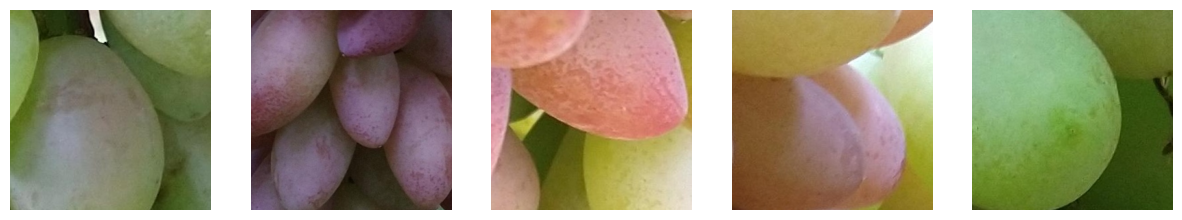

Image 48 has size: torch.Size([3, 293, 293])
Image 46 has size: torch.Size([3, 293, 293])
Image 265 has size: torch.Size([3, 293, 293])
Image 240 has size: torch.Size([3, 293, 293])
Image 190 has size: torch.Size([3, 293, 293])


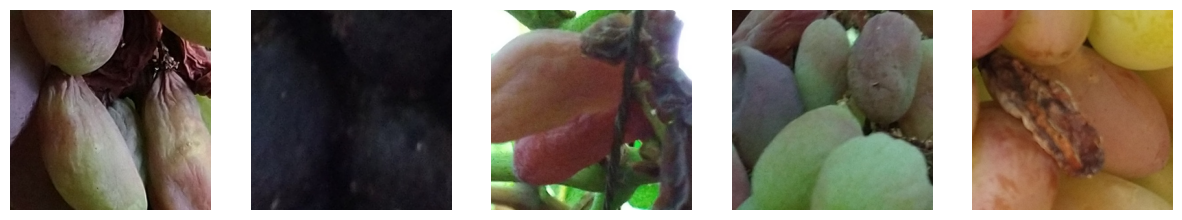

In [11]:
num_images_to_plot = 5
plot_images(healthy_test_dataset, num_images=num_images_to_plot, labeled=True, random_seed=10)
plot_images(anomaly_test_dataset, num_images=num_images_to_plot, labeled=True, random_seed=10)

Now we will compute some statistics about out dataset.

In [12]:
def compute_mean_and_std_loss(autoencoder, dataloader):
    autoencoder.eval()
    reconstruction_losses = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = criterion(outputs, images).cpu().detach().numpy()
            reconstruction_losses.append(loss)

    reconstruction_losses = np.array(reconstruction_losses)
    mean_loss = np.mean(reconstruction_losses)
    std_loss = np.std(reconstruction_losses)

    return mean_loss, std_loss, reconstruction_losses

healthy_mean_loss, healthy_std_loss, healthy_losses = compute_mean_and_std_loss(autoencoder, healthy_dataloader)
anomalous_mean_loss, anomalous_std_loss, anomaly_losses = compute_mean_and_std_loss(autoencoder, anomaly_dataloader)
test_mean_loss, test_std_loss, test_losses = compute_mean_and_std_loss(autoencoder, test_dataloader)

print("Healthy - Mean Loss:", healthy_mean_loss, "Std Loss:", healthy_std_loss)
print("Anomalous - Mean Loss:", anomalous_mean_loss, "Std Loss:", anomalous_std_loss)
print("Overall - Mean Loss:", test_mean_loss, "Std Loss:", test_std_loss)


Healthy - Mean Loss: 0.006271797 Std Loss: 0.00050545204
Anomalous - Mean Loss: 0.007585397 Std Loss: 0.0008522037
Overall - Mean Loss: 0.0071328166 Std Loss: 0.0009685005


We need to compute some statistics about the autoencoder's performance, statistics that we can later use for fine tuning and for finding the best threshold.
A first approach we could try is using the following metrics:


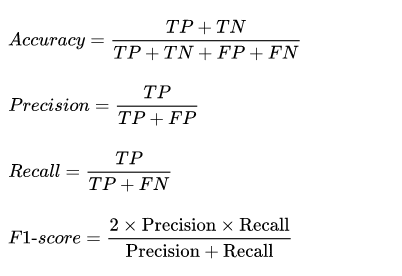

In [14]:
def compute_stats(healthy_losses, anomaly_losses, threshold):
    true_positives = sum([1 for l in anomaly_losses if l >= threshold])
    false_positives = sum([1 for l in healthy_losses if l >= threshold])
    true_negatives = sum([1 for l in healthy_losses if l < threshold])
    false_negatives = sum([1 for l in anomaly_losses if l < threshold])

    total_accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return (true_positives, false_positives, true_negatives, false_negatives, total_accuracy, precision, recall, f1_score)

# Fine-tuning
threshold = np.mean(test_losses)
prev_threshold = 0.0
tolerance = 0.0001
max_iterations = 1000
best_accuracy = 0.0

iteration = 0
while abs(threshold - prev_threshold) > tolerance and iteration < max_iterations:
    prev_threshold = threshold

    true_positives, false_positives, true_negatives, false_negatives, total_accuracy, precision, recall, f1_score = compute_stats(healthy_losses, anomaly_losses, threshold)

    # Print or store the evaluation metrics for the current threshold
    print("Iteration n. ", iteration)
    print("Threshold:", threshold)
    print("True Positives:", true_positives)
    print("False Positives:", false_positives)
    print("True Negatives:", true_negatives)
    print("False Negatives:", false_negatives)
    print("Accuracy:", total_accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("====================")

    # Check if the current threshold gives a better accuracy
    if total_accuracy > best_accuracy:
        best_accuracy = total_accuracy
        best_threshold = threshold

    # Adjust the threshold based on your preference
    threshold -= 0.001  # Decrease the threshold by a small amount, adjust as desired

    iteration += 1

# Print the best threshold and its corresponding accuracy
print("The values converged after ", iteration, " iterations")
print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)


Output streaming troncato alle ultime 5000 righe.
Recall: 1.0
F1 Score: 0.7741935483870968
Iteration n.  546
Threshold: -0.5388671834059063
True Positives: 12
False Positives: 7
True Negatives: 0
False Negatives: 0
Accuracy: 0.631578947368421
Precision: 0.631578947368421
Recall: 1.0
F1 Score: 0.7741935483870968
Iteration n.  547
Threshold: -0.5398671834059063
True Positives: 12
False Positives: 7
True Negatives: 0
False Negatives: 0
Accuracy: 0.631578947368421
Precision: 0.631578947368421
Recall: 1.0
F1 Score: 0.7741935483870968
Iteration n.  548
Threshold: -0.5408671834059063
True Positives: 12
False Positives: 7
True Negatives: 0
False Negatives: 0
Accuracy: 0.631578947368421
Precision: 0.631578947368421
Recall: 1.0
F1 Score: 0.7741935483870968
Iteration n.  549
Threshold: -0.5418671834059063
True Positives: 12
False Positives: 7
True Negatives: 0
False Negatives: 0
Accuracy: 0.631578947368421
Precision: 0.631578947368421
Recall: 1.0
F1 Score: 0.7741935483870968
Iteration n.  550
Thr

We see that the threshold converges after just 1 iteration, which means that the changes in the threshold do not affect greatly our metrics. This means that the model predictions have a consistent pattern. I also tried to use other metrics instead of accuracy, such as the f1 score, but the result is always the same.

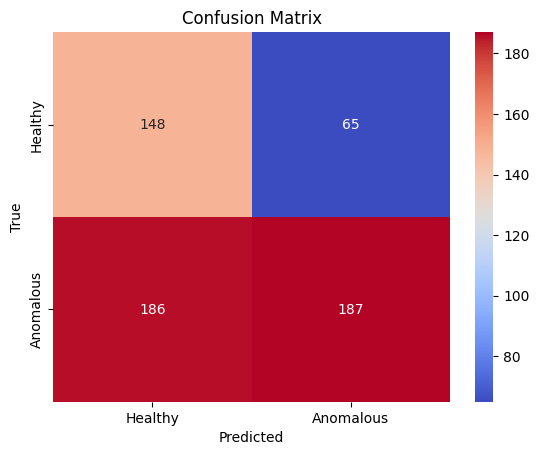

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize counters for TP, TN, FP, and FN
TP = 0
TN = 0
FP = 0
FN = 0

# Evaluate the autoencoder on the test dataset
for images, labels in test_dataloader:
    images = images.to(device)
    # Perform the reconstruction
    outputs = autoencoder(images)

    for i in range(len(images)):
      loss = mse_loss(images[i], outputs[i])
      if loss > best_threshold:
        if labels[i].item() == 1:
            TP += 1
        else:
            FP += 1
      else:
          if labels[i].item() == 0:
              TN += 1
          else:
              FN += 1

# Create a confusion matrix
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Plot the heatmap
labels = ['Healthy', 'Anomalous']
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


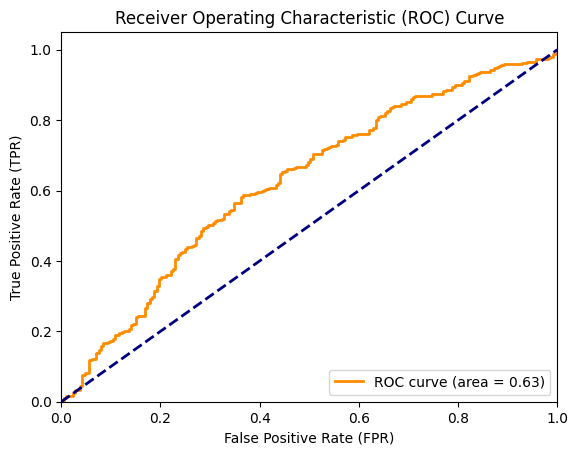

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(test_dataloader, autoencoder, best_threshold):
    autoencoder.eval()  # Set the model to evaluation mode

    # Initialize lists to store losses and true labels
    losses = []
    true_labels = []

    # Evaluate the autoencoder on the test dataset and compute reconstruction losses
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            # Perform the reconstruction
            outputs = autoencoder(images)

            for i in range(len(images)):
                loss = mse_loss(images[i], outputs[i]).item()
                label = labels[i].item()
                losses.append(loss)
                true_labels.append(label)

    # Convert the true labels list to a NumPy array
    true_labels = np.array(true_labels)

    # Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
    fpr, tpr, thresholds = roc_curve(true_labels, losses)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming you already have the autoencoder, test_dataloader, and best_threshold set up
plot_roc_curve(test_dataloader, autoencoder, best_threshold)


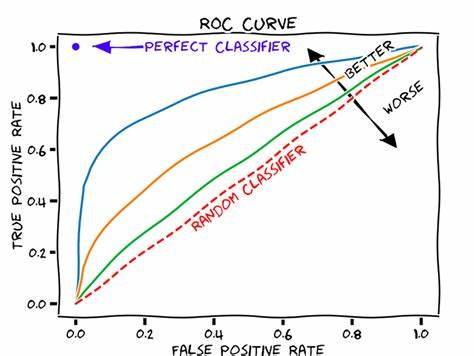

From the ROC curve we can deduce that the autoencoder operates better than a random classifier, however there still is margin of improvement.

# Failure modes
Finally, let's see in which cases our autoencoder fails in the classification to obtain additional insights.

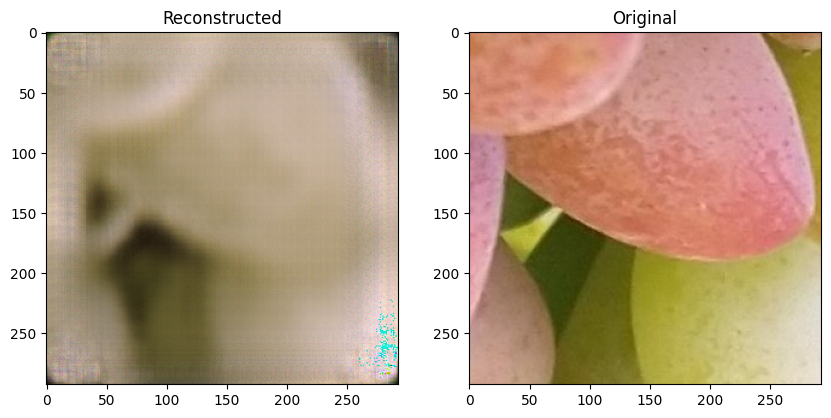

Loss calculated: 0.011008924804627895 > Best Threshold = 0.007132816594094038


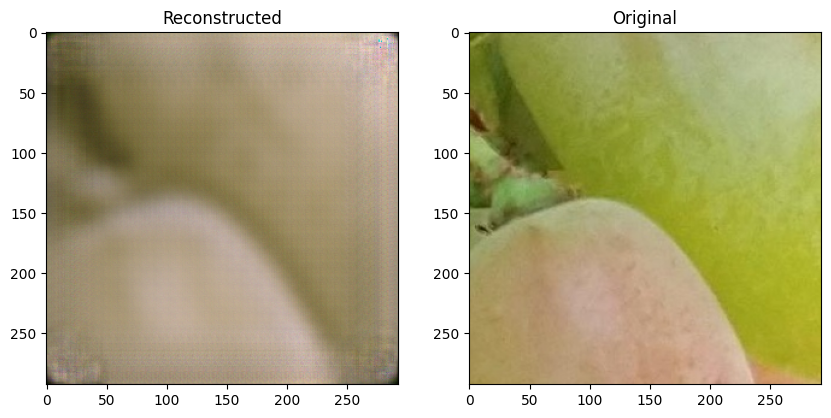

Loss calculated: 0.009575123898684978 > Best Threshold = 0.007132816594094038


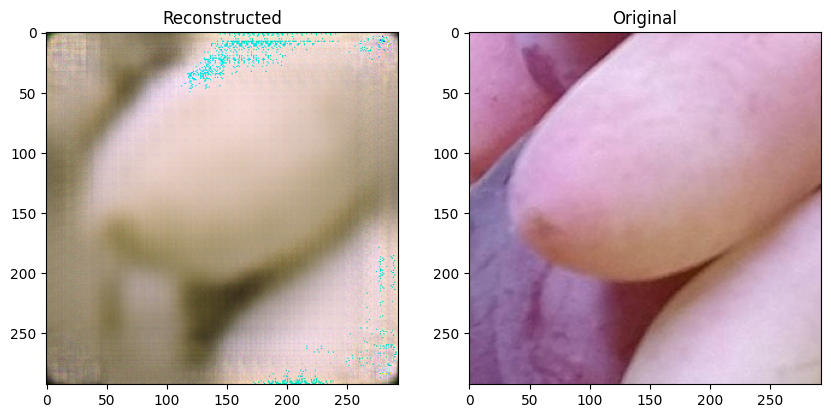

Loss calculated: 0.00948253646492958 > Best Threshold = 0.007132816594094038


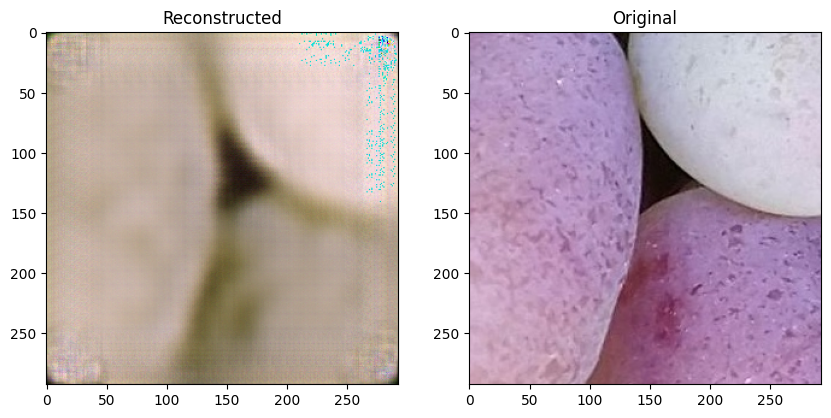

Loss calculated: 0.012322824448347092 > Best Threshold = 0.007132816594094038


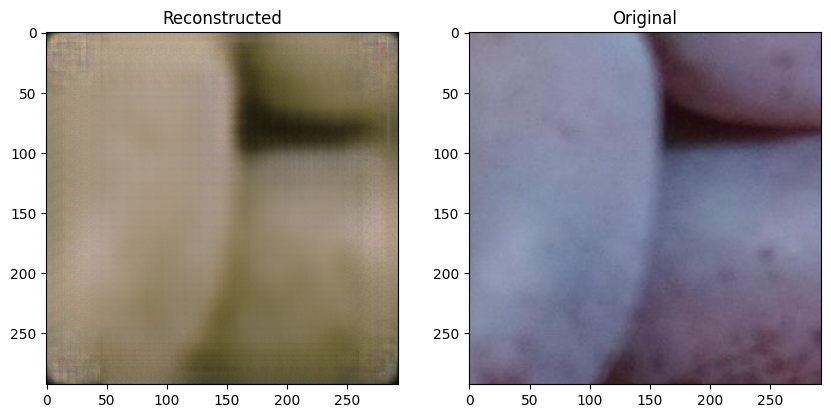

Loss calculated: 0.013449610210955143 > Best Threshold = 0.007132816594094038


In [17]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def reconstruct_and_print_images(model, dataloader, criterion, best_threshold, num_cases):
    model.eval()
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            outputs = model(data)

            for i in range(len(outputs)):
                if(num_cases == 0): break
                loss = criterion(outputs[i], data[i]).item()

                # Reconstruct and print if the loss is greater than the best threshold
                if loss > best_threshold:
                    num_cases -= 1
                    original_image = TF.to_pil_image(data[i].cpu())
                    reconstructed_image = TF.to_pil_image(outputs[i].cpu())

                    _, ax = plt.subplots(1, 2, figsize=(10, 5))
                    ax[0].set_title("Reconstructed")
                    ax[0].imshow(reconstructed_image)
                    ax[1].set_title("Original")
                    ax[1].imshow(original_image)
                    plt.show()

                    print(f"Loss calculated: {loss} > Best Threshold = {best_threshold}")

# Show healthy berries incorrectly classified as unhealthy
num_cases = 5
reconstruct_and_print_images(autoencoder, healthy_dataloader, criterion, best_threshold, num_cases)


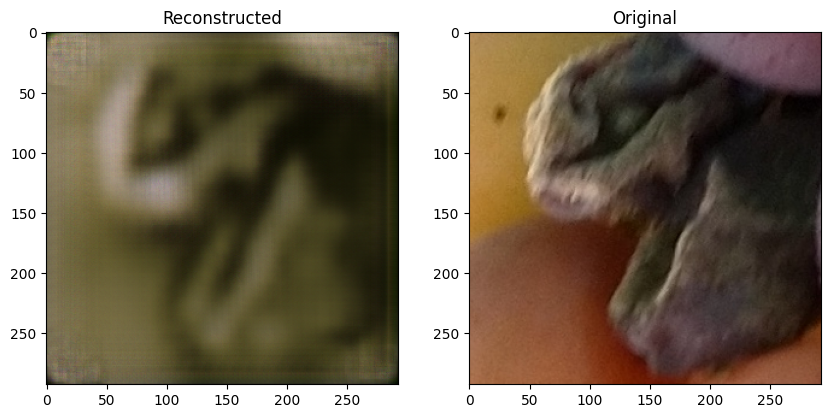

Loss calculated: 0.006731513887643814 < Best Threshold = 0.007132816594094038


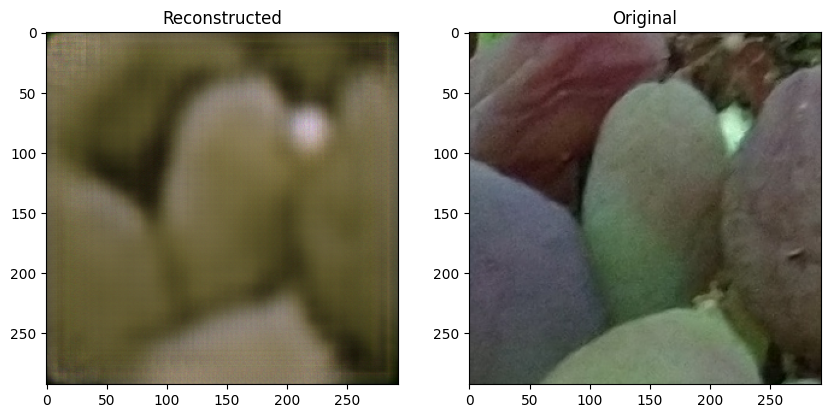

Loss calculated: 0.006271754391491413 < Best Threshold = 0.007132816594094038


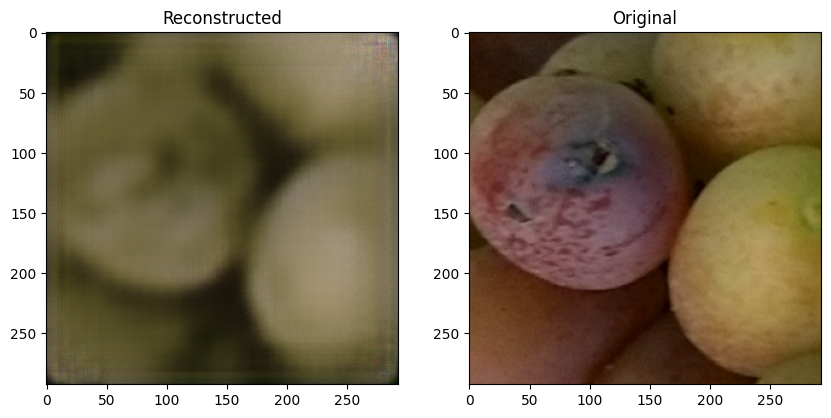

Loss calculated: 0.005151292774826288 < Best Threshold = 0.007132816594094038


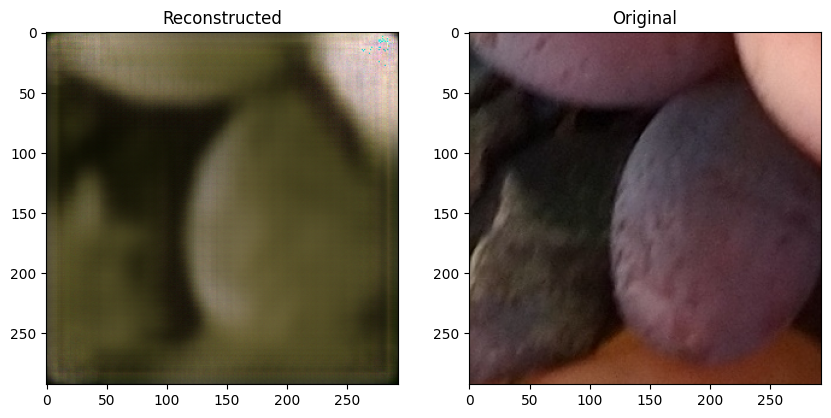

Loss calculated: 0.006181567907333374 < Best Threshold = 0.007132816594094038


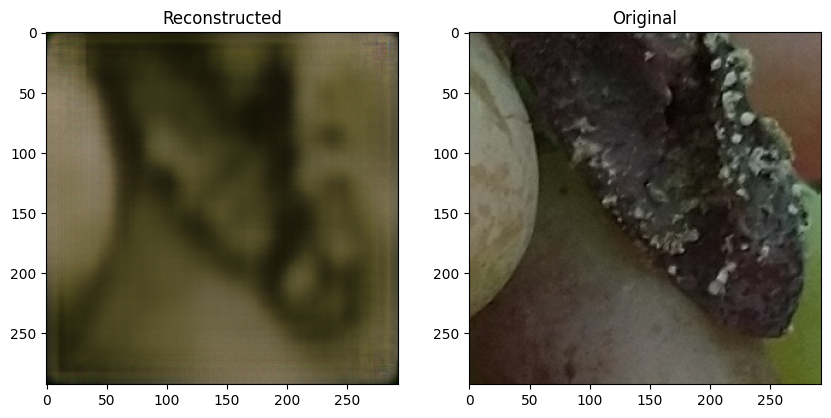

Loss calculated: 0.0052904109470546246 < Best Threshold = 0.007132816594094038


In [18]:
def reconstruct_and_print_anomalous_images(model, dataloader, criterion, best_threshold, num_cases):
    model.eval()
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            outputs = model(data)

            for i in range(len(outputs)):
                if(num_cases == 0): break
                loss = criterion(outputs[i], data[i]).item()

                # Reconstruct and print if the loss is less than the best threshold
                if loss < best_threshold:
                    num_cases -= 1
                    original_image = TF.to_pil_image(data[i].cpu())
                    reconstructed_image = TF.to_pil_image(outputs[i].cpu())

                    _, ax = plt.subplots(1, 2, figsize=(10, 5))
                    ax[0].set_title("Reconstructed")
                    ax[0].imshow(reconstructed_image)
                    ax[1].set_title("Original")
                    ax[1].imshow(original_image)
                    plt.show()

                    print(f"Loss calculated: {loss} < Best Threshold = {best_threshold}")

# Show unhealthy berries misclassified as healthy
num_cases = 5
reconstruct_and_print_anomalous_images(autoencoder, anomaly_dataloader, criterion, best_threshold, num_cases)
